# Code demonstration : Quantum Neural Networks

## Quantum classifier

In [1]:
import sklearn
import sklearn.datasets
import pennylane as qml
import matplotlib.pyplot as plt

from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

### 1. Load and preprocess the dataset

We prepare the Wine dataset for the classification task. For simplicity, we focus on the first two classes of the Wine dataset.

We apply normalization to rescale the 13 attributes per sample to the interval [0, π]. Furthermore, the labels are remapped from {0, 1} to {−1, 1} to align with the output range of the quantum circuit model.

In [2]:
def load_wine(split_ratio = 0.5):
    feat, label = sklearn.datasets.load_wine(return_X_y=True)

    # normalization
    feat = np.pi * (feat - np.min(feat, axis=0, keepdims=True)) / np.ptp(feat, axis=0, keepdims=True)

    index_c0 = label == 0
    index_c1 = label == 1

    label = label * 2 - 1

    n_c0 = sum(index_c0)
    n_c1 = sum(index_c1)

    X_train = np.concatenate((feat[index_c0][:int(split_ratio*n_c0)], feat[index_c1][:int(split_ratio*n_c1)]), axis=0)
    y_train = np.concatenate((label[index_c0][:int(split_ratio*n_c0)], label[index_c1][:int(split_ratio*n_c1)]), axis=0)
    X_test = np.concatenate((feat[index_c0][int(split_ratio*n_c0):], feat[index_c1][int(split_ratio*n_c1):]), axis=0)
    y_test = np.concatenate((label[index_c0][int(split_ratio*n_c0):], label[index_c1][int(split_ratio*n_c1):]), axis=0)

    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = load_wine()

To better understand the dataset, we apply t-SNE to visualize its distribution.

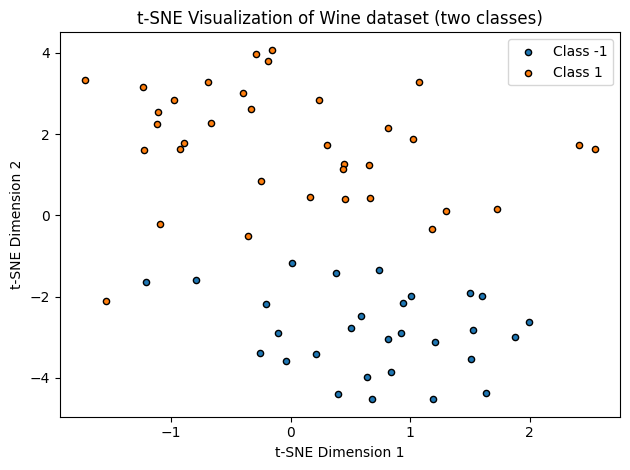

In [4]:
def visualize_dataset(X, y):
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)

    wine_tsne = tsne.fit_transform(X)
    for label in np.unique(y):
        indices = y == label
        plt.scatter(
            wine_tsne[indices, 0], 
            wine_tsne[indices, 1], 
            edgecolor='black', 
            s=20, 
            label=f'Class {label}'
        )

    # Add labels and legend
    plt.title("t-SNE Visualization of Wine dataset (two classes)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()

    plt.tight_layout()
    plt.show()
visualize_dataset(X_train, y_train)

### 2. Implement a quantum read-in protocol to encode clasical data into quantum states

To encode the 13 attributes of the Wine dataset into a quantum system, we use angle encoding, followed by a layer of CNOT gates acting on neighboring qubits to introduce entanglement.

In [5]:
def data_encoding(x):
    n_qubit = len(x)
    qml.AngleEmbedding(features =x , wires = range(n_qubit) , rotation ="X")
    for i in range(n_qubit):
        if i+1 < n_qubit:
            qml.CNOT(wires=[i, i+1])

### 3. Construct a parameterized quantum circuit model to process the input quantum states

The circuit model is composed of multiple layers, where each layer includes parameterized single-qubit rotation gates with trainable angles, followed by a block of non-parametric CNOT gates to introduce entanglement among qubits.

To read-out the category information of each input sample from the prepared quantum state, we compute the expectation value of the Pauli-Z operator on the first qubit.

In [6]:
def classifier(param, x=None):
    data_encoding(x)
    n_layer, n_qubit = param.shape[0], param.shape[1]
    for i in range(n_layer):
        for j in range(n_qubit):
            qml.Rot(param[i, j, 0], param[i, j, 1], param[i, j, 2], wires=j)
        for j in range(n_qubit):
            if j+1 < n_qubit:
                qml.CNOT(wires=[j, j+1])
    return qml.expval(qml.PauliZ(0))

n_qubit = X_train.shape[1]
dev = qml.device('default.qubit', wires=n_qubit)
circuit = qml.QNode(classifier, dev)

We visualize the whole quantum circuit of 2 layers by drawing the diagram.

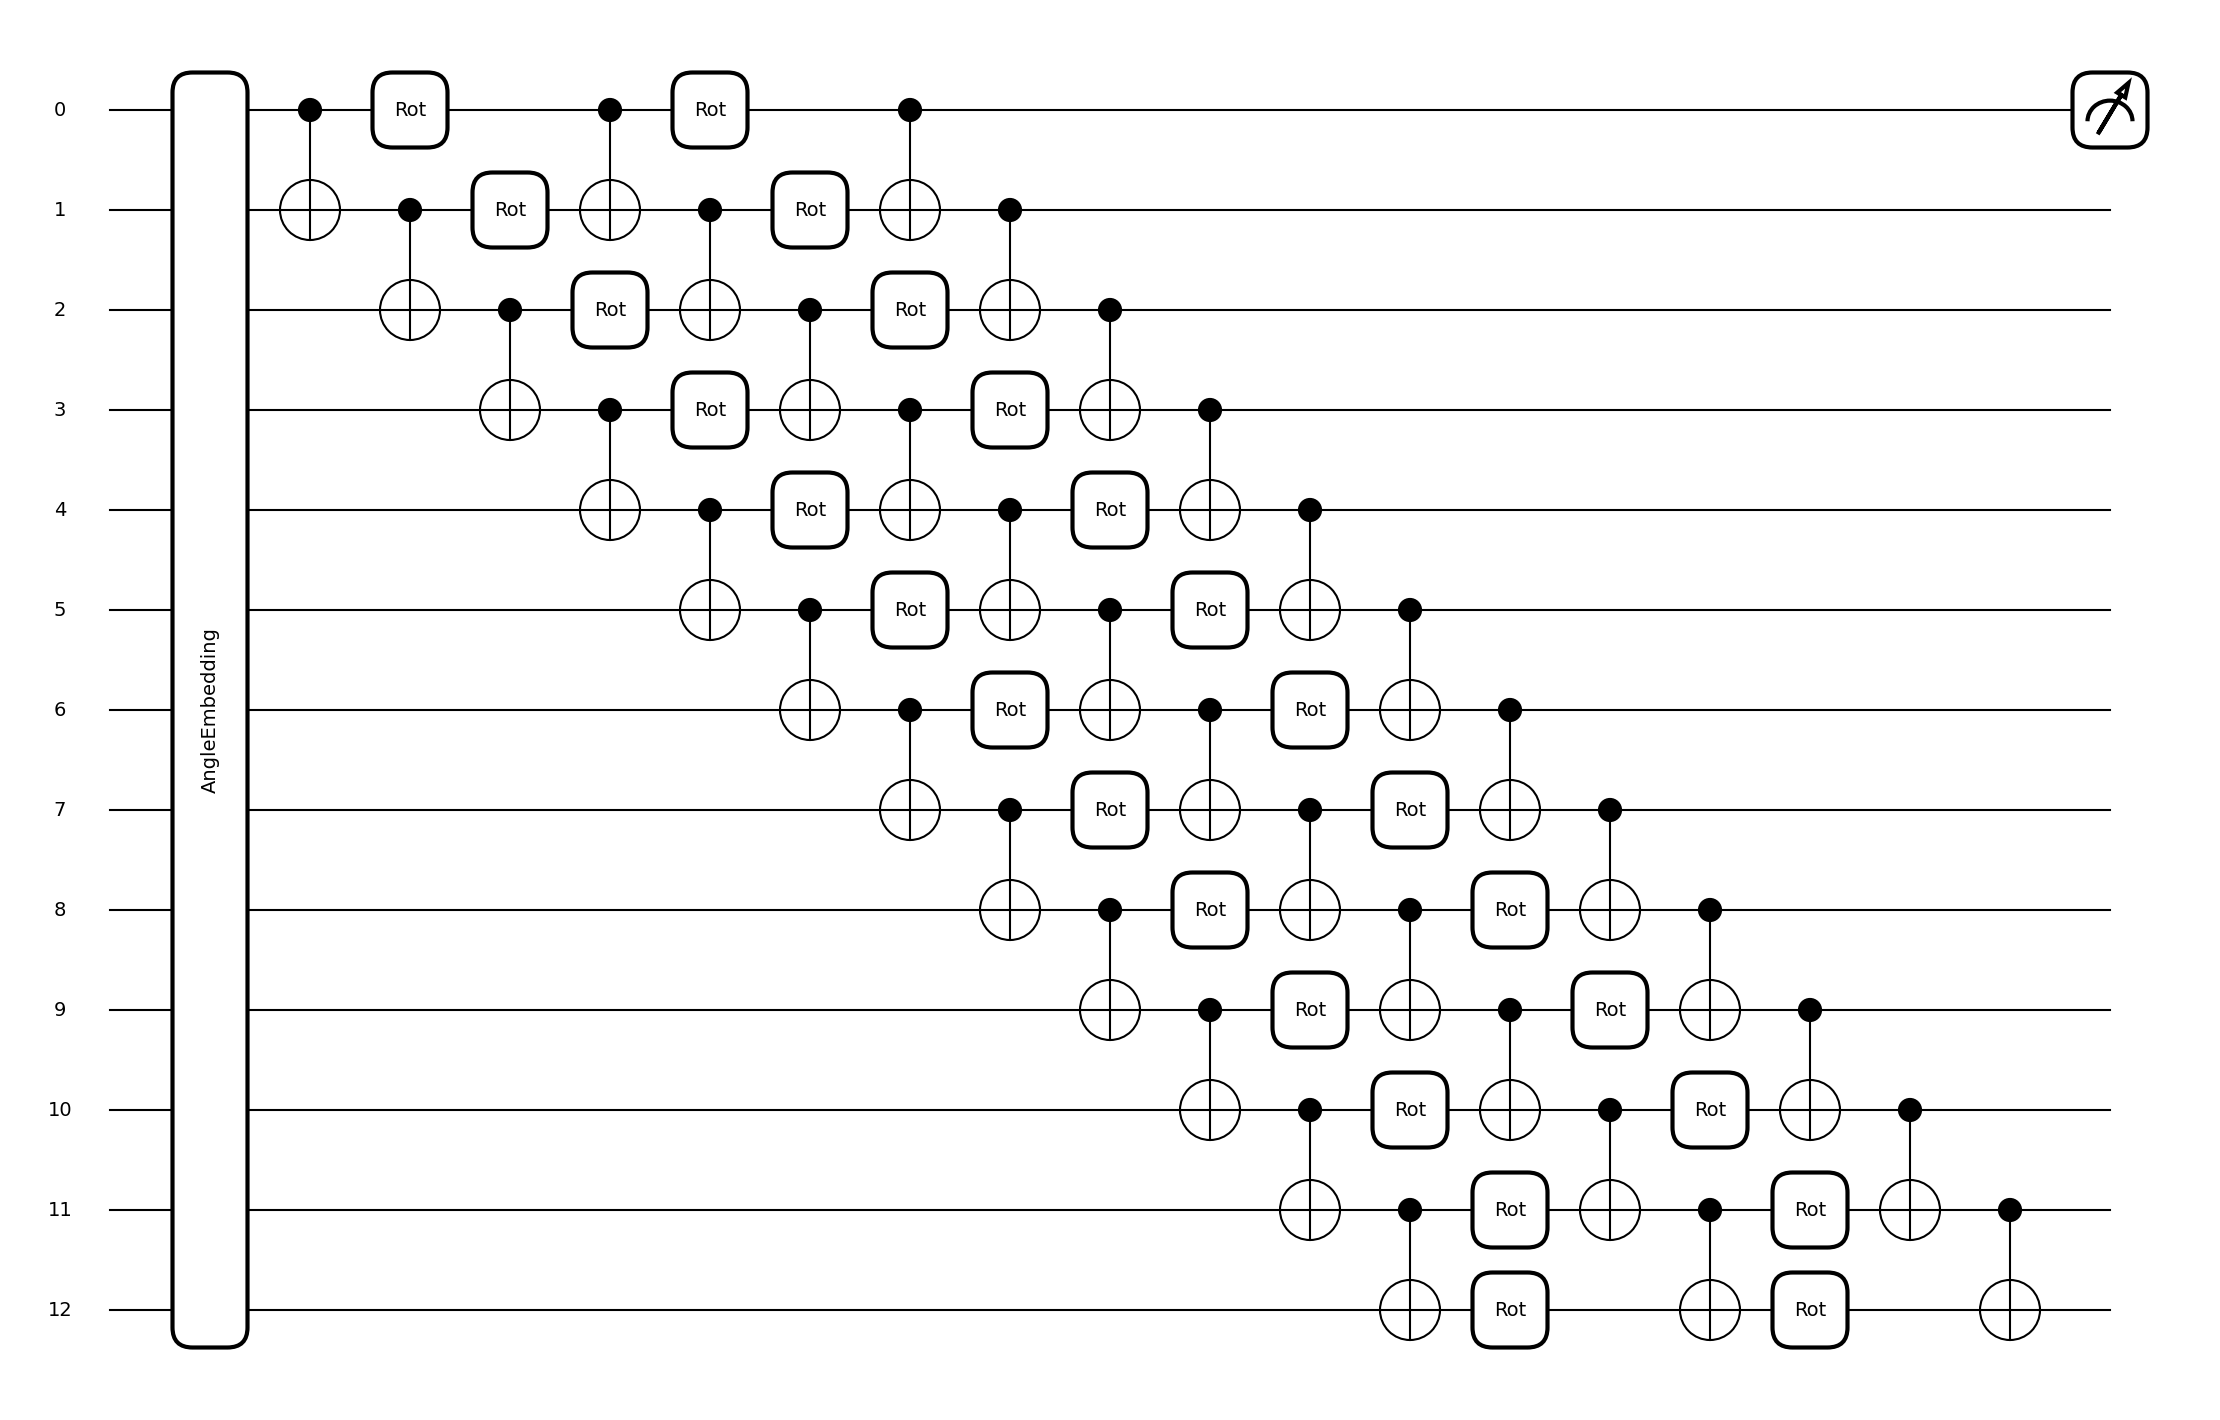

In [8]:
fig, ax = qml.draw_mpl(circuit)(np.pi * np.random.randn(2, n_qubit, 3), X_train[0])

### 4. Train and test the QNN to evaluate its performance

 The mean squared error (MSE) is used as the loss function.

In [9]:
def mse_loss(predict, label):
    return np.mean((predict - label)**2)

def cost(param, circuit, X, y):
    exp = []
    for i in range(len(X)):
        pred = circuit(param, x=X[i])
        exp.append(pred)
    return mse_loss(np.array(exp), y)

To evaluate the performance of the quantum classifier, we use classification accuracy as the metric. Specifically, if the sign of the read-out result matches the corresponding label, the prediction is considered correct; otherwise, it is deemed incorrect.

In [10]:
def accuracy(predicts, labels):
    assert len(predicts) == len(labels)
    return np.sum((np.sign(predicts)*labels+1)/2)/len(predicts)

The Adam optimizer is utilized to minimize the loss function. To ensure efficient computation, the dataset is divided into smaller batches for each training iteration

In [11]:
n_layer = 4
param = np.pi * np.random.randn(n_layer, n_qubit, 3)

lr = 0.01
opt = AdamOptimizer(lr)
batch_size = 4

n_epoch = 50
cost_train, cost_test, acc_train, acc_test = [], [], [], []
for i in range(n_epoch):
    index = np.random.permutation(len(X_train))
    feat_train, label_train = X_train[index], y_train[index]
    for j in range(0, len(X_train), batch_size):
        feat_train_batch = feat_train[j*batch_size:(j+1)*batch_size]
        label_train_batch = label_train[j*batch_size:(j+1)*batch_size]
        param = opt.step(lambda v: cost(v, circuit, feat_train_batch, label_train_batch), param)
    
    # compute cost
    cost_train.append(cost(param, circuit, X_train, y_train))
    cost_test.append(cost(param, circuit, X_test, y_test))

    # compute accuracy
    pred_train = []
    for j in range(len(X_train)):
        pred_train.append(circuit(param, x=X_train[j]))
    acc_train.append(accuracy(np.array(pred_train), y_train))

    pred_test = []
    for j in range(len(X_test)):
        pred_test.append(circuit(param, x=X_test[j]))
    acc_test.append(accuracy(np.array(pred_test), y_test))

C:\Users\ho.aabela\AppData\Roaming\Python\Python313\site-packages\numpy\_core\fromnumeric.py:3858: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\ho.aabela\AppData\Roaming\Python\Python313\site-packages\pennylane\numpy\tensor.py:152: RuntimeWarning: invalid value encountered in divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
C:\Users\ho.aabela\AppData\Roaming\Python\Python313\site-packages\autograd\tracer.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


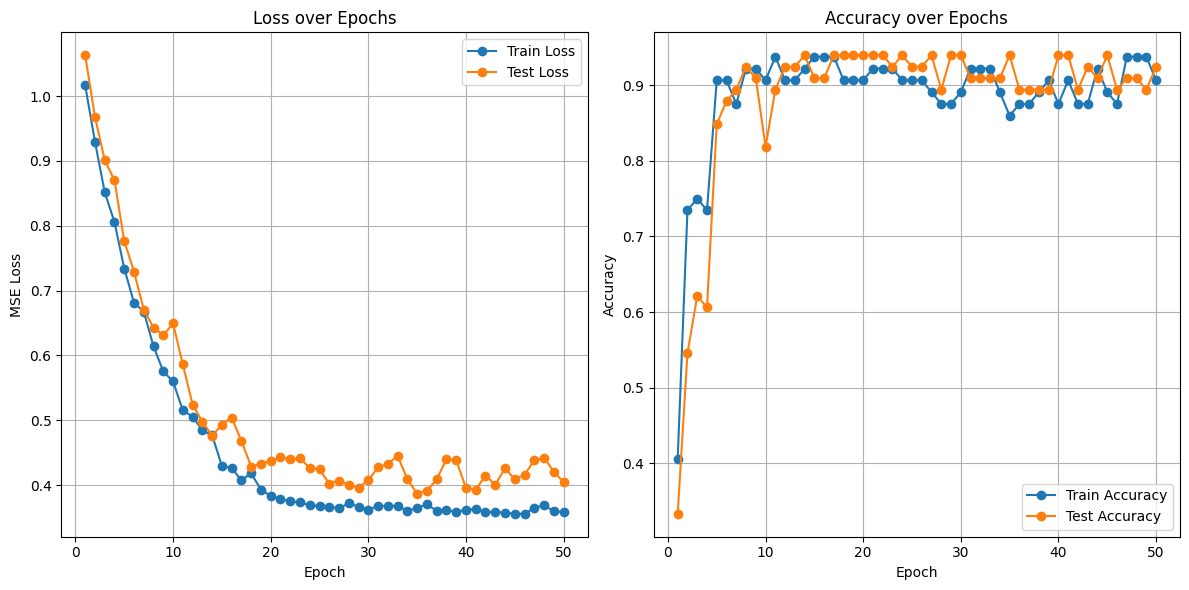

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
epochs = np.arange(1, n_epoch + 1)
plt.plot(epochs, cost_train, label='Train Loss', marker='o')
plt.plot(epochs, cost_test, label='Test Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_train, label='Train Accuracy', marker='o')
plt.plot(epochs, acc_test, label='Test Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Quantum patch GAN

In [15]:
import math
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### 1. Load and preprocess the dataset

We will use the Optical Recognition of Handwritten Digits dataset (optdigits), where each data point represents an 8 × 8 grayscale image.

In [16]:
class OptdigitsData(Dataset):
    def __init__(self, data_path, label):
        """
        Dataset class for Optical Recognition of Handwritten Digits.
        """
        super().__init__()

        self.data = []
        with open(data_path, 'r') as f:
            for line in f.readlines():
                if int(line.strip().split(',')[-1]) == label:
                    # Normalize image pixel values from [0,16) to [0, 1)
                    image = [int(pixel)/16 for pixel in line.strip().split(',')[:-1]]
                    image = np.array(image, dtype=np.float32).reshape(8, 8)
                    self.data.append(image)
        self.label = label

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return torch.from_numpy(self.data[index]), self.label

After defining the dataset, we can visualize a few examples to better understand the structure of the dataset.

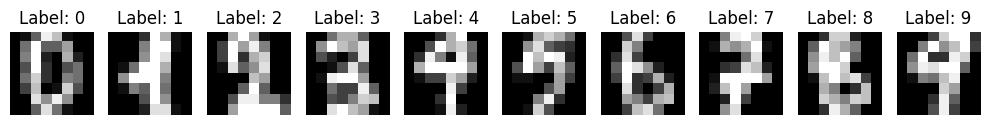

In [18]:
def visualize_dataset(data_path):
    """
    Visualizes the dataset by displaying examples for each digit label.
    """
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        data = OptdigitsData(data_path, label=i)
        plt.imshow(data[0][0], cmap='gray')
        plt.title(f"Label: {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_dataset('optical+recognition+of+handwritten+digits/optdigits.tra')

### 2. Build the classical discriminator

The discriminator is a classical neural network responsible for distinguishing real images from fake ones.

In [19]:
class ClassicalDiscriminator(nn.Module):
    """
    A classical discriminator for classifying real and fake images.
    """
    def __init__(self, input_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(np.prod(input_shape)), 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

### 3. Build the quantum generator

The generator in the quantum patch GAN consists of parameterized quantum circuits (PQC).

Specifically, the PQC applies layers of single-qubit rotation gates and entangling gates to the latent state

In [20]:
def PQC(params):
    n_layer, n_qubit = params.shape[0], params.shape[1]
    for i in range(n_layer):
        for j in range(n_qubit):
            qml.Rot(params[i, j, 0], params[i, j, 1], params[i, j, 2], wires=j)
        # Control Z gates
        for j in range(n_qubit - 1):
            qml.CZ(wires=[j, j + 1])

Then, we implement the quantum generator for each patch of an image, i.e., sub-generators.

The sub-generator transforms the latent variable z into a latent quantum state |z⟩, applies a PQC, performs partial measurements on the ancillary system A, and outputs the probabilities of each computational basis state in the remaining system, which correspond to the generated pixel values.


In [21]:
def QuantumGenerator(params, z=None, n_qubit_a=1):
    n_qubit = params.shape[1]

    # angle encoding of latent state z
    for i in range(n_qubit):
        qml.RY(z[i], wires=i)

    PQC(params)

    # partial measurement on the ancillary qubits
    qml.measure(wires=n_qubit-1)
    return qml.probs(wires=range(n_qubit-n_qubit_a))

Using the sub-generators, the quantum patch generator combines the output patches from multiple sub-generators to construct the complete image.

In [22]:
class PatchQuantumGenerator(nn.Module):
    """
    Combines patches generated by quantum circuits into full images.
    """
    def __init__(self, qnode_generator, n_generator, n_qubit, n_qubit_a, n_layer):
        super().__init__()

        self.params_generator = nn.ParameterList([
            nn.Parameter(torch.rand((n_layer, n_qubit, 3)), requires_grad=True) for _ in range(n_generator)
        ])
        self.qnode_generator = qnode_generator
        self.n_qubit_a = n_qubit_a

    def forward(self, zs):
        images = []
        for z in zs:
            patches = []
            for params in self.params_generator:
                patch = self.qnode_generator(params, z=z, n_qubit_a=self.n_qubit_a).float()

                # post-processing: min-max scaling
                patch = (patch - patch.min()) / (patch.max() - patch.min() + 1e-8)

                patches.append(patch.unsqueeze(0))
            patches = torch.cat(patches, dim=0)
            images.append(patches.flatten().unsqueeze(0))
        return torch.cat(images, dim=0)

### 4. Train the quantum patch GAN

In [23]:
# Hyperparameters
torch.manual_seed(0)
image_width = 8
image_height = 8
n_generator = 4
n_qubit_d = int(np.log2((image_width * image_height) // n_generator))
n_qubit_a = 1
n_qubit = n_qubit_d + n_qubit_a
n_layer = 6

# Quantum device
dev = qml.device("lightning.qubit", wires=n_qubit)
qnode_generator = qml.QNode(QuantumGenerator, dev)

# Initialize generator and discriminator
discriminator = ClassicalDiscriminator([image_height, image_width])
discriminator.train()
generator = PatchQuantumGenerator(qnode_generator, n_generator, n_qubit, n_qubit_a, n_layer)
generator.train()

# Optimizers
lr_generator = 0.3
lr_discriminator = 1e-2
opt_discriminator = optim.SGD(discriminator.parameters(), lr=lr_discriminator)
opt_generator = optim.SGD(generator.parameters(), lr=lr_generator)

# Construct dataset and dataloader
batch_size = 4
dataset = OptdigitsData('optical+recognition+of+handwritten+digits/optdigits.tra', label=5)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Loss function
loss_fn = nn.BCELoss()
labels_real = torch.ones(batch_size, dtype=torch.float)
labels_fake = torch.zeros(batch_size, dtype=torch.float)

# Testing setup
n_test = 10
z_test = torch.rand(n_test, n_qubit) * math.pi

The GAN training process involves alternating updates for the discriminator and the generator.

To track the generator’s progress during training, the generated images are saved at the end of each epoch.

In [24]:
n_epoch = 10
record = {}
for i in range(n_epoch):
    for data, _ in dataloader:

        zs = torch.rand(batch_size, n_qubit) * math.pi
        image_fake = generator(zs)

        # Training the discriminator
        discriminator.zero_grad()
        pred_fake = discriminator(image_fake.detach())
        pred_real = discriminator(data)

        loss_discriminator = loss_fn(pred_fake.squeeze(), labels_fake) + loss_fn(pred_real.squeeze(), labels_real)
        loss_discriminator.backward()
        opt_discriminator.step()

        # Training the generator
        generator.zero_grad()
        pred_fake = discriminator(image_fake)
        loss_generator = loss_fn(pred_fake.squeeze(), labels_real)
        loss_generator.backward()
        opt_generator.step()

    print(f'The {i}-th epoch: discriminator loss={loss_discriminator: 0.3f}, generator loss={loss_generator: 0.3f}')

    # test
    generator.eval()
    image_generated = generator(z_test).view(n_test, image_height, image_width).detach()

    record[str(i)] = {
        'loss_discriminator': loss_discriminator.item(),
        'loss_generator': loss_generator.item(),
        'image_generated': image_generated.numpy().tolist()
    }
    generator.train()

The 0-th epoch: discriminator loss= 1.190, generator loss= 0.703
The 1-th epoch: discriminator loss= 1.001, generator loss= 0.801
The 2-th epoch: discriminator loss= 0.821, generator loss= 0.954
The 3-th epoch: discriminator loss= 0.758, generator loss= 1.124
The 4-th epoch: discriminator loss= 0.645, generator loss= 1.995


KeyboardInterrupt: 

### 5. Visualize the generated images

After training, we visualize the images generated by the quantum generator to evaluate its performance.

In [ ]:
n_epochs_to_visualize = len(record) // 2
n_images_per_epoch = 10

fig, axes = plt.subplots(n_epochs_to_visualize, n_images_per_epoch, figsize=(n_images_per_epoch, n_epochs_to_visualize))

# Iterate through the recorded epochs and visualize generated images
for epoch_idx, (epoch, data) in enumerate(record.items()):
    if epoch_idx % 2 == 1:
        continue
    images = np.array(data['image_generated'])
    
    for img_idx in range(n_images_per_epoch):
        ax = axes[epoch_idx // 2, img_idx]
        ax.imshow(images[img_idx], cmap='gray')
        ax.axis('off')
        
        # Add epoch information to the title of each row
        if img_idx == 0:
            ax.set_title(f"Epoch {epoch}", fontsize=10)

plt.tight_layout()
plt.show()